# DATA COLLECTION, CLEAN-UP AND ANALYSIS:
## THE MOST VANILLA SUPER HERO EVER
*By: Claudio Davi*

**Who is the most vanilla super hero ever? Can we create one?**

I asked myself this question the other day and decided to test some of my skills with data. In this notebook, I'll guide you throughout my thinking process during the pursuit of the answer.

## Imports

Those are the libraries used to make this happen.

In [ ]:
from bs4 import BeautifulSoup
import urllib3
import pandas as pd
from collections import defaultdict

## Web Scraping

First, I had to find a website that cointained all the information I needed for this project, after a couple of hours I've found 
superherodb.com with a very thorough list of super heroes with their information, and respective powers. So I built a web scraper to get that data.

In [ ]:
http = urllib3.PoolManager()
url = "http://www.superherodb.com"

def get_data(http, link):
    '''
    Gets the main power page from superhero db
    returns Beautifulsoup object
    '''
    wiki = http.request('GET', link)
    data = BeautifulSoup(wiki.data, 'html.parser')
    return data

def get_hero_links(data):
    herolinks = []
    
    for link in data.find_all("li", {"class": "char-li"}):
        for hero in link.find_all('a'):
            herolinks.append(url + hero["href"]) 
    return herolinks


def get_hero_characteristics(hero_links):
    #should return a list of heroes characteristics
    hero_dicts = []
    for hero_link in hero_links:
        d = {}
        data = get_data(http, hero_link)
        hero_name = data.find('h1').get_text()
        tr = data.find_all('tr')
        d['name'] = hero_name
        for table in tr: 
            td = table.find_all('td')
            d[td[0].get_text()] = td[1].get_text()
        hero_dicts.append(d)
    return hero_dicts

def get_power_links(data):
    '''
    gets the web site links for all powers
    returns a list of links
    '''
    powerlinks = []
    for link in data.find_all('a'):
        if "/powers/" in link.get('href'):
            powerlinks.append(url + link["href"])
    return powerlinks

def get_superhero_powers(links):
    '''
    from all links received scrape that page for the power name
    and add to a dict with lists as values.
    returns the dictionary
    '''
    powers = defaultdict(list)
    for link in links[1:]:
        data = get_data(http, link)
        power_name = data.find('h1').get_text()
        for hero_name in data.find_all("span", {"class": "card2-title"}):
            powers[hero_name.get_text()].append(power_name)
    return powers

def transform_data_into_csv(super_hero_powers, csv_name):
    '''
    from the dictionary created with the web scraper we create a dataframe and save it to
    csv
    '''
    df = pd.DataFrame(dict([ (hero,pd.Series(power)) for hero,power in super_hero_powers.items() ]))
    df.to_csv(csv_name)

## This is probably going to take a while, so we will save everything into csv files

In [ ]:
data = get_data(http,"http://www.superherodb.com/powers")
power_links = get_power_links(data)
super_hero_dict = get_superhero_powers(power_links)
transform_data_into_csv(super_hero_dict)

In [ ]:
hero_data = get_data(http, "http://www.superherodb.com/characters/")
herolinks = get_hero_links(hero_data)
hero_dict = get_hero_characteristics(herolinks)
df = pd.DataFrame.from_dict(hero_dict)
df = df[['name', 'Gender', 'Eye color', 'Race', 'Hair color', 'Height', 'Publisher', 'Skin color', 'Alignment', 'Weight']]
df.to_csv("heros_info.csv")

## Cleaning Data

We saved our data into a csv so we do not need to make requests everytime. But this csv is not optimal for our analysis yet. We will have to clean and manipulate it.

In [ ]:
df = pd.read_csv('super_hero_with_powers.csv')
#get rid of this guy
del df['Unnamed: 0']


pwrs = df.stack().unique()
L = [pd.Series(df[x].unique(), index=df[x].unique()).reindex(index=pwrs) for x in df.columns]
df1 = pd.concat(L, axis=1, keys=df.columns)
df1 = df1.eq(df1.index.values, axis=0)
df1.index.name = 'power_names'
df1.columns.names = ['hero_names']
df1 = df1.T
df1.to_csv('super_hero_powers.csv')
df1.head()

In [ ]:
df = pd.read_csv('heros_info.csv')

def measurements_in_metrics(row, ix):
    h = row.split()
    return h[ix]

df['Height'] = df['Height'].apply(lambda x : measurements_in_metrics(x, 2))
df['Weight'] = df['Weight'].apply(lambda x : measurements_in_metrics(x, 3))

df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')
del df['Unnamed: 0']
df.to_csv('super_hero_infos.csv')
df.head()

In [ ]:
heros_info = pd.read_csv('super_hero_infos.csv')
hero_powers = pd.read_csv('super_hero_powers.csv')

In [ ]:
heros_info.head()

In [ ]:
hero_powers.head()

In [ ]:
heros_info['Height'].describe()

In [ ]:
heros_info['Weight'].describe()

In [ ]:
heros_info['Weight'].sort_values(ascending=False).head()

In [ ]:
heros_info['Height'].sort_values(ascending=False).head()

In [ ]:
heros_info['Weight'].replace(to_replace=0, value=heros_info.Weight.mean(), inplace = True )
heros_info['Weight'].fillna(value=heros_info.Weight.mean(), inplace=True)

In [ ]:
heros_info['Height'].replace(to_replace=0, value=heros_info.Height.mean(), inplace = True )

In [ ]:
del heros_info['Unnamed: 0']

In [ ]:
heros_info.describe()

In [ ]:
#I'm going to take a break now, so I'll save our cleaned data into that same csv.
heros_info.to_csv('super_hero_infos.csv')

In [ ]:
hero_power.head()

## Cleaning and preparation done. Let's go to the fun part...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#lets start again...
hero_info = pd.read_csv('super_hero_infos.csv')
hero_power = pd.read_csv('super_hero_powers.csv')

In [3]:
# Ok, I'm not proud of this thing right here. But it's is not stupid if it works, right?!
power_num = hero_power.sum()
#I had to create an intemediate guy with True and false sorted out,
#giving me only the huper powers shared by at least 2 super heroes
common_powers = (power_num == True).sort_values()[:-14].index

In [4]:
most_common_powers = hero_power[common_powers].sum()
common_result = most_common_powers[1:].sort_values(ascending=False)[:10]

In [5]:
sns.set_style("whitegrid")
sns.set_style("ticks")

### First plot comming up
I honestly went through several iterations of this plot before I got satisfied with the result.

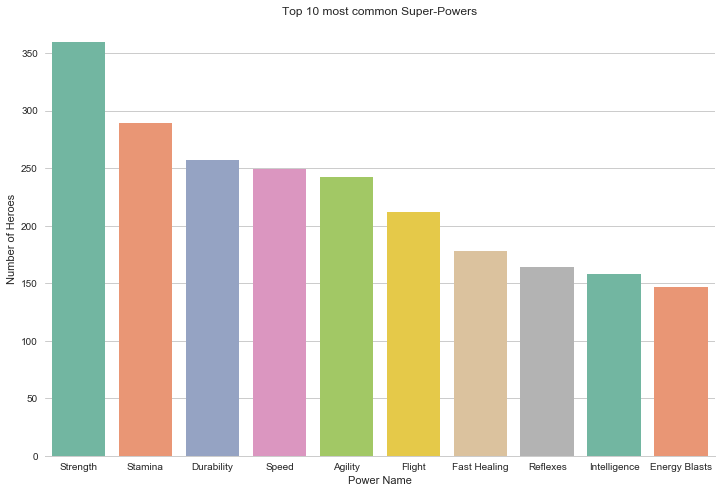

In [21]:
plt.figure(figsize=(12,8))
c = sns.barplot(x=common_result.index, y = common_result, palette=sns.color_palette("Set2", 10))
#plt.setp(c.get_xticklabels())
sns.despine(left=True)
sns.set_style("whitegrid")
c.set_title("Top 10 most common Super-Powers")
c.set_xlabel("Power Name")
c.set_ylabel("Number of Heroes")
c.set(xticklabels=["Strength", "Stamina", "Durability", "Speed","Agility","Flight",
                   "Fast Healing","Reflexes","Intelligence", "Energy Blasts"])

plt.savefig("common_powers.png")
plt.show()

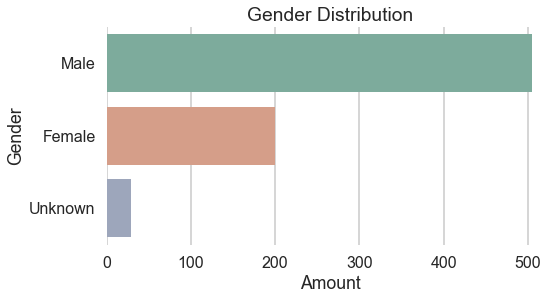

In [84]:
plt.figure(figsize=(8,4))
g = sns.countplot(y="Gender", data=hero_info, palette="Set2", saturation=0.5)
g.set(yticklabels=["Male", "Female", "Unknown"])
g.set_xlabel("Amount")
sns.despine(left=True, offset=0.5, bottom=True)
g.set_title('Gender Distribution')
plt.savefig("super_heroes_gender.png")

In [75]:
hero_info['Eye color'] = hero_info['Eye color'].str.replace('-', 'Unknown').fillna('Unknown').str.lower()

In [ ]:
hero_info['Gender'] = hero_info['Gender'].str.replace('-', 'Unknown')

[[<matplotlib.text.Text at 0x1ea65b4dac8>,

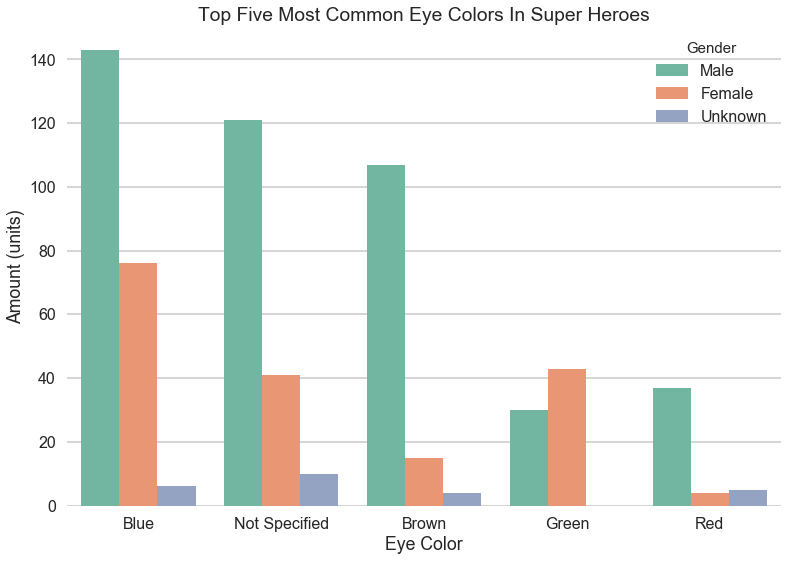

In [104]:
sns.set_context(context="poster")
e = sns.countplot(x=hero_info['Eye color'], data=hero_info, hue='Gender', 
              order=hero_info['Eye color'].value_counts().iloc[:5].index, palette=sns.color_palette("Set2"))
sns.despine(offset=5, left=True, bottom=True)
e.set_title("Top Five Most Common Eye Colors In Super Heroes")
e.set_xlabel("Eye Color")
e.set_ylabel("Amount (units)")
e.set(xticklabels=["Blue", "Not Specified", "Brown", "Green", "Red"])
#plt.savefig("Eye_color_distribution.png")

In [105]:
#Let's see what we can explore...
hero_info.head()

,Unnamed: 0,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
0,0,A-Bomb,Male,yellow,Human,No Hair,203.0,Marvel Comics,NaN,good,441.0
1,1,Abe Sapien,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,Blue,good,65.0
2,2,Abin Sur,Male,blue,Ungaran,No Hair,185.0,DC Comics,Red,good,90.0
3,3,Abomination,Male,green,Human / Radiation,No Hair,203.0,Marvel Comics,NaN,bad,441.0
4,4,Abraxas,Male,blue,Cosmic Entity,Black,0.0,Marvel Comics,NaN,bad,0.0
